# Text Generation

## Understanding Language
Language is one of the most complex aspects of our existence. We use language to communicate our thoughts and choices. Every language is defined with a list of characters called the alphabet, a vocabulary and a set of rules called grammar. Yet it is not a trivial task to understand and learn a language.

It takes years for a human to grasp a few languages, let alone become a master of it. Most languages have vast vocabularies which are ever expanding along with complex and fuzzy grammatical rules and structures. We see/think and write/share differently. To put simply, languages are ambiguous. The ambiguity, sarcasm, context, and continuous changes to usage patterns are some of the challenges associated with language.

__Examples of ambiguity__

- The bowler made the batsman _duck_.
> The word _duck_, is it verb or noun?

- Stolen painting found by _tree_.
> The word _tree_, is it an actor or a place?

- Are you comfortable with _python_?
> The word _python_, is it representing the programming language python or a snake or something else?



## Recurrent Networks and Seq2Seq

Recurrent Neural Networks (RNNs) and their gated cell variants such as Long Short Term Memory Cells (LSTMs) and Gated Recurrent Units (GRUs) provided a mechanism for language modeling, i.e. they can learn word ordering and provide predictions for next word in a sequence. This allows us to use RNNs for generative tasks, such as __text generation__, machine translation, and even image captioning.

RNNs allow for different neural architectures that are shown in the picture below:
<img src="../../assets/module_2/rnn_setup_nb_2.jpeg">

> source:  [Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

- **One-to-one** is a traditional neural network with one input and one output
- **One-to-many** is a generative architecture that accepts one input value, and generates a sequence of output values. For example, if we want to train image captioning network that would produce a textual description of a picture, we can have a picture as input, pass it through CNN to obtain hidden state, and then have recurrent chain generate caption word-by-word
- **Many-to-one** corresponds to RNN architectures we described in the previous unit, such as text classification
- **Many-to-many**, or sequence-to-sequence corresponds to tasks such as machine translation or language translation, where we have first RNN collect all information from the input sequence into the hidden state, and another RNN chain unrolls this state into the output sequence.

## Language Modeling
By far the most widely used application from the NLP world is language modeling. We use it daily on our phone keyboards, email applications and a ton of other places.

In simple words, a language model takes certain text as input context to generate the next set of words as output. This is interesting because a language model tries to understand the input context, the language structure (though in a very naive way) to predict the next word(s). We use it in the form of text completion utilities on search engines, chat platforms, emails etc. all the time. Language models are a perfect real life application of NLP and showcase the power of RNNs.

Language models can be developed train in different ways. The most common and widely used method is the sliding window approach. The model takes a small window of text as input and tried to predict the next word as the output. The following figure illustrates the same visually.

<img src="../../assets/module_2/lm_training_nb_2.png">



Now, we will focus on simple generative models that help us generate text. For simplicity, let's build a character-level network, which generates news articles text letter by letter. While generating news articles may seem quite impractical, the same idea of sequence generation is used in many practical tasks, such as machine translation, text summarization, etc.

During training, we need to take some text corpus, and split it into letter sequences.

<a target="_blank" href="https://colab.research.google.com/github/raghavbali/llm_workshop_dhs23/blob/main/module_02/solutions/1.%20simple_text_generator.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [19]:
import re
import os
import numpy as np
from collections import Counter, OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import torch.utils.data as data
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## A quick snippet of the book

In [21]:
!wget -O sherlock_homes.txt http://www.gutenberg.org/files/1661/1661-0.txt

--2023-07-12 10:05:26--  http://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/1661/1661-0.txt [following]
--2023-07-12 10:05:27--  https://www.gutenberg.org/files/1661/1661-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607430 (593K) [text/plain]
Saving to: ‘sherlock_homes.txt’

sherlock_homes.txt  100%[===================>] 593.19K  1.15MB/s    in 0.5s    

2023-07-12 10:05:28 (1.15 MB/s) - ‘sherlock_homes.txt’ saved [607430/607430]



In [22]:
filename = "sherlock_homes.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()

In [23]:
print(raw_text[1500:1600])

she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she


## Prepare Text

In [24]:
text = raw_text [1450:]
text = text.lower()

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        params,
    ):
        self.params = params
        args = None
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        text = self.params['text']
        return [word for word in re.split(' |\n|,|!',text) if word != '']

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.params['sequence_length']

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.params['sequence_length']]),
            torch.tensor(self.words_indexes[index+1:index+self.params['sequence_length']+1]),
        )

In [26]:
params = {
    'sequence_length': 100,
    'text': text
}

dataset = Dataset(params)

## Prepare a Simple LSTM Based Text Generator

In [27]:
class RNNGen(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size, num_layers):
        super(RNNGen, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.embed = torch.nn.Embedding(input_size, embed_size)
        self.lstm = torch.nn.LSTM(input_size=embed_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.init_hidden = torch.nn.Parameter(torch.zeros(
                                              num_layers, 1, hidden_size))

    def forward(self, features, hidden_state):
        embedded = self.embed(features)# .view(1, -1)
        output, hidden_state = self.lstm(embedded,hidden_state)#.view(1, 1, -1))
        #output = output[:, -1, :]
        output = self.fc(output)#.view(1, -1))
        return output, hidden_state

    def init_zero_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.hidden_size),
                torch.zeros(self.num_layers, sequence_length, self.hidden_size))

In [28]:
model = RNNGen(
    input_size = len(dataset.get_uniq_words()),
    output_size = len(dataset.get_uniq_words()),
    embed_size = 512,
    hidden_size = 64,
    num_layers = 2
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [29]:
print(model)

RNNGen(
  (embed): Embedding(12141, 512)
  (lstm): LSTM(512, 64, num_layers=2)
  (fc): Linear(in_features=64, out_features=12141, bias=True)
)


## Utilities to Train and Predict

In [31]:
def generate_text(dataset, model, prompt_text, next_words=10):
    words = prompt_text.split(' ')
    #model.eval()

    state_h, state_c = model.init_zero_state(len(words))

    print(f"Prompt Text = {prompt_text}")
    print("-"*25)
    print("Generated Text -> \n")
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits.cpu(), dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

In [30]:
def train(dataset, model, params):
    loss_list = []
    model.train()

    dataloader = DataLoader(
        dataset,
        batch_size=params['batch_size'],
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(params['max_epochs']):
        state_h, state_c = model.init_zero_state(params['sequence_length'])

        for batch, (x, y) in enumerate(dataloader):

            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
            loss = criterion(y_pred.transpose(1, 2), y.to(device))

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            if batch%10 == 0:
              print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
            loss_list.append(loss.item())
            if batch%128 == 0:
              print(' '.join(generate_text(dataset, model, prompt_text='watson what are you')))
    return loss_list

## Let Us Build Our First Text Generator
> Did any one say Language Models?

In [32]:
params['max_epochs'] = 5
params['batch_size'] = 512

model_loss = train(dataset, model, params)

{'epoch': 0, 'batch': 0, 'loss': 9.408352851867676}
Prompt Text = watson what are you
-------------------------
Generated Text -> 

watson what are you scenery rolling sentence—‘this association sable. to-morrow?” case-book sailor freedom sailing-ship.
{'epoch': 0, 'batch': 10, 'loss': 9.334738731384277}
{'epoch': 0, 'batch': 20, 'loss': 8.880098342895508}
{'epoch': 0, 'batch': 30, 'loss': 7.962679386138916}
{'epoch': 0, 'batch': 40, 'loss': 7.0475311279296875}
{'epoch': 0, 'batch': 50, 'loss': 7.046125888824463}
{'epoch': 0, 'batch': 60, 'loss': 7.037005424499512}
{'epoch': 0, 'batch': 70, 'loss': 6.8647308349609375}
{'epoch': 0, 'batch': 80, 'loss': 7.096351146697998}
{'epoch': 0, 'batch': 90, 'loss': 6.789387226104736}
{'epoch': 0, 'batch': 100, 'loss': 6.991313934326172}
{'epoch': 0, 'batch': 110, 'loss': 6.870967388153076}
{'epoch': 0, 'batch': 120, 'loss': 7.0650954246521}
Prompt Text = watson what are you
-------------------------
Generated Text -> 

watson what are you lengths 

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt

Text(0.5, 0, 'epochs')

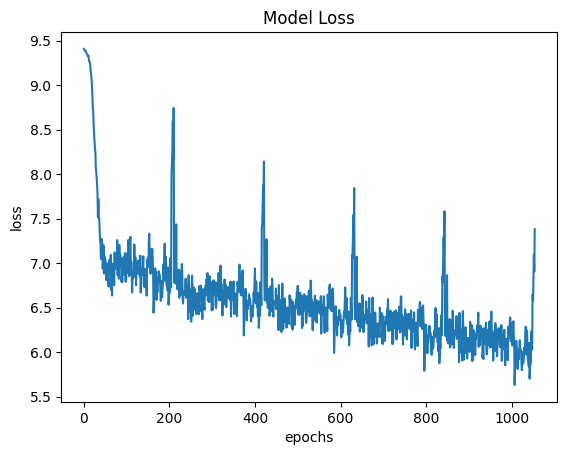

In [34]:
sns.lineplot(
    y=model_loss,
    x=range(len(model_loss))
)
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epochs")

In [46]:
print(' '.join(generate_text(dataset, model, prompt_text='i am writing this prompt', next_words=25)))

Prompt Text = i am writing this prompt
-------------------------
Generated Text -> 

i am writing this prompt abruptly; array take?” approach result yourself she would in an morning was and at the course and not “‘do in the laid and there was


## Decoding Strategies

The ``generate_text`` utility we used above used every output prediction as input for the next time step. This method of using the highest probability prediction as output is called __Greedy Decoding__. Greeding decoding is fast and simple but is marred with issues we saw in samples we just generated.

Focusing on only highest probability output narrows our model's focus to just the next step which inturn may result in inconsistent or non-dictionary terms/words.

### Beam Search
Beam search is the obvious next step to improve the output predictions from the model. Instead of being greedy, beam search keeps track of n paths at any given time and selects the path with overall higher probability.

<img src="../../assets/module_2/beamsearch_nb_2.png">

### Other Key Decoding Strategies:
- Sampling
- Top-k Sampling
- Nucleus Sampling

### Temperature
Though sampling helps bring in required amount of randomness, it is not free from issues. Random sampling leads to gibberish and incoherence at times. To control the amount of randomness, we introduce __temperature__. This parameter helps increase the likelihood of high probability terms reduce the likelihood of low probability ones. This leads to sharper distributions. 

> High temperature leads to more randomness while lower temperature brings in predictability.


### The RNN Limitation
The RNN layer (LSTM, or GRU, etc.) takes in a context window of a defined size as input and encodes all of it into a single vector. This bottleneck vector needs to capture a lot of information in itself before the decoding stage can use it to start generating the next token.

## Attention is All You Need

<img src="../../assets/module_1/transformer_notebook_1.jpg">


### Attention to the Rescue
Attention is one of the most powerful concepts in the deep learning space that really changed the game. The core idea behind the attention mechanism is to make use of all interim hidden states of the RNN to decide which one to focus upon before it is used by the decoding stage. 

### Contextual Embeddings
The [TagLM architecture by Peters et al. in 2017](https://arxiv.org/abs/1705.00108) was one of the first works that provided an insight into how we could combine __pre-trained word embeddings__ with a __pre-trained neural language model__ to generate __context-aware embeddings__ for downstream NLP tasks.

The big breakthrough that changed the NLP landscape came in the form of __ELMo, or Embeddings from Language Models__. The ELMo architecture was presented by Peters et al. in their work titled [__Deep Contextualized Word Representations in 2018__](https://arxiv.org/abs/1802.05365). Without going into too much detail, the main highlights of the ELMo architecture were:

- The model used a bi-LSTM-based language model.
- Character CNNs were used to generate embeddings, in place of pre-trained word vectors, which made use of huge 4096 LSTM units but transformed into smaller 512-sized vectors using feedforward layers.
- The main innovation was to make use of all the hidden bi-LSTM layers for generating input representation. Unlike previous works, where only the final LSTM layer was used to fetch the representation of the input, this work took a weighted average of all the hidden layers' hidden states. This helped the model learn contextual word embeddings where each layer contributed to things like syntax and semantics.

## Self-Attention
- Self-attention was proposed by Cheng et al. in their paper titled Long Short-Term Memory Networks for Machine Reading in 2016
- Self-attention enables a model to learn the correlation between the current token (character or word or sentence, etc.) and its context window. In other words, it is an attention mechanism that relates different positions of a given sequence so as to generate a representation of the same sequence

## Transformers
- The transformer architecture was presented in the seminal paper __Attention is All You Need__ by Vaswani et al. back in 2017
- A transformer is a __recurrence-__ and __convolution-free__ attention-based encoder-decoder architecture
- Introduced the concept of multi-head attention and positional encodings
- Also revolutionalised Computer Vision domain (see ViT)


<img src="../../assets/module_1/transformer_arch_notebook_1.png">


## BERT-ology
- BERT, or __[Bi-Directional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)__, was presented by Devlin et al., a team at Google AI in 2018
- Multi-task Learning: BERT also helped push the transfer-learning envelope in the NLP domain by showcasing how a pre-trained model can be fine-tuned for various tasks to provide state-of-the-art performance
- BERT tweaked the usual Language Model objective to only predict next token based on past context by building context from both directions, i.e. the objective of predicting masked words along with next sentence prediction.


<img src="../../assets/module_1/bert_models_layout_notebook_1.jpeg">

> source [PLM Papers](https://github.com/thunlp/PLMpapers)

